## Parametrization of a organic molecule with GAFF
Amber is a suite of biomolecular simulation programs that allows users to carry out molecular dynamics simulations1. It consists of several independently developed packages that work well by themselves and with each other.

The preprocessing tools in Amber include:
* `Antechamber` and `MCPB.py`: These are programs used to create force fields for general organic molecules and metal centers1.
* `tleap` and `parmed`: These are basic preparatory tools for Amber simulations1.
  
Such tools are perfec to to build chemical systems and performs molecular dynamics simulation with OpenMM and the Amber forcefield.

### Antechamber

**Antechamber** is a part of the Amber suite of biomolecular simulation programs. It is a set of auxiliary programs designed for molecular mechanic (MM) studies¹. The main functionalities of Antechamber include¹:

1. Recognizing the atom type.
2. Recognizing bond type.
3. Judging the atomic equivalence.
4. Generating residue topology file.
5. Finding missing force field parameters and supplying reasonable and similar substitutes.

Antechamber can generate input automatically for most organic molecules in a database¹. It is used to create parameters for non-standard amino acids and drug-like molecules³. It is designed to be used with the "general AMBER force field (GAFF)"⁴, which covers most of the organic chemical space².

The programs in the Antechamber package include am1bcc, antechamber, atomtype, bondtype, crdgrow, database, delphigen, espgen, parmcal, parmchk, prepgen, respgen, translate, and top2mol2¹. Each of these programs has specific functions. For example, am1bcc is used to assign atom types and bond types according to AM1-BCC definitions¹.

Please note that while Antechamber is a powerful tool, it is not a replacement for due diligence. Users should always closely examine the atom types that Antechamber assigns and verify that the choices are reasonable². For the most accurate and detailed information, it's always a good idea to refer to the official Amber documentation or reach out to the Amber community.

Now let's try using antechamber on our 3HB pdb file. To create the "mol2" file, required to define a new unit in LEaP (described later), we simply run the following command:
(https://ambermd.org/tutorials/basic/tutorial4b/)

```shell
antechamber -i inputs/3HB.pdb -fi pdb -o outputs/3HB.mol2 -fo mol2 -c bcc -s 2
```

In [3]:
!antechamber -i inputs/3HB.pdb -fi pdb -o outputs/3HB.mol2 -fo mol2 -c bcc -s 2

'antechamber' is not recognized as an internal or external command,
operable program or batch file.


The residue unit 3HB has been generated. We can use the utility parmchk2 to test if all the parameters we require are available:

In [2]:
!parmchk2 -i outputs/3HB.mol2 -f mol2 -o outputs/3HB.frcmod

'parmchk2' is not recognized as an internal or external command,
operable program or batch file.


The 3HB.frcmod output of this command is:

```shell
Remark line goes here
MASS

BOND

ANGLE

DIHE

IMPROPER

NONBON
```

So, there is not missing parameters. We can start to build the topology and paramters for simulation with tLeap.

### tLeap

**tleap** is a part of the Amber suite of biomolecular simulation programs. It serves as a bridge between various chemical structure file types (like .pdb and .mol2) and the Amber model parameter file types such as .lib, .prepi, parm.dat, and .frcmod². 

Here are some key points about tleap²¹:

1. It generates an Amber topology file (with extensions like .prmtop, .parm7, .top) and a coordinate file (with extensions like .inpcrd, .crd) based on a complete set of parameters (the molecular model, which we call a "force field").
2. It is used to prepare systems for Amber simulations³.
3. It merges information in the PDB and lib files together by first matching residue names and then matching atom names. If there are any missing atoms, tleap will add them automatically¹.

Please note that while tleap is a powerful tool, it is not a replacement for due diligence. Users should always closely examine the atom types that tleap assigns and verify that the choices are reasonable². For the most accurate and detailed information, it's always a good idea to refer to the official Amber documentation or reach out to the Amber community.


In [ ]:
source leaprc.gaff
3HB  = loadMol2 outputs/3HB.mol2
list
saveoff 3HB outputs/3HB.lib
saveamberparm 3HB outputs/3HB.prmtop outputs/3HB.rst7

The last command returns:

```shell
> saveamberparm 3HB 3HB.prmtop 3HB.rst7        
Checking Unit.
Building topology.
Building atom parameters.
Building bond parameters.
Building angle parameters.
Building proper torsion parameters.
!FATAL ERROR----------------------------------------
!FATAL:    In file [/home/conda/feedstock_root/build_artifacts/ambertools_1698676863694/work/AmberTools/src/leap/src/leap/unitio.c], line 1955
!FATAL:    Message: 1-4: cannot add bond 5 6
This may be caused by duplicate bond specifications;
for example, explicit bond commands in addition to PDB conect records.
!
!ABORTING.
```

It seems atom 5 and 6 are double bounded. It corresponds to the molecule carbonyl group:

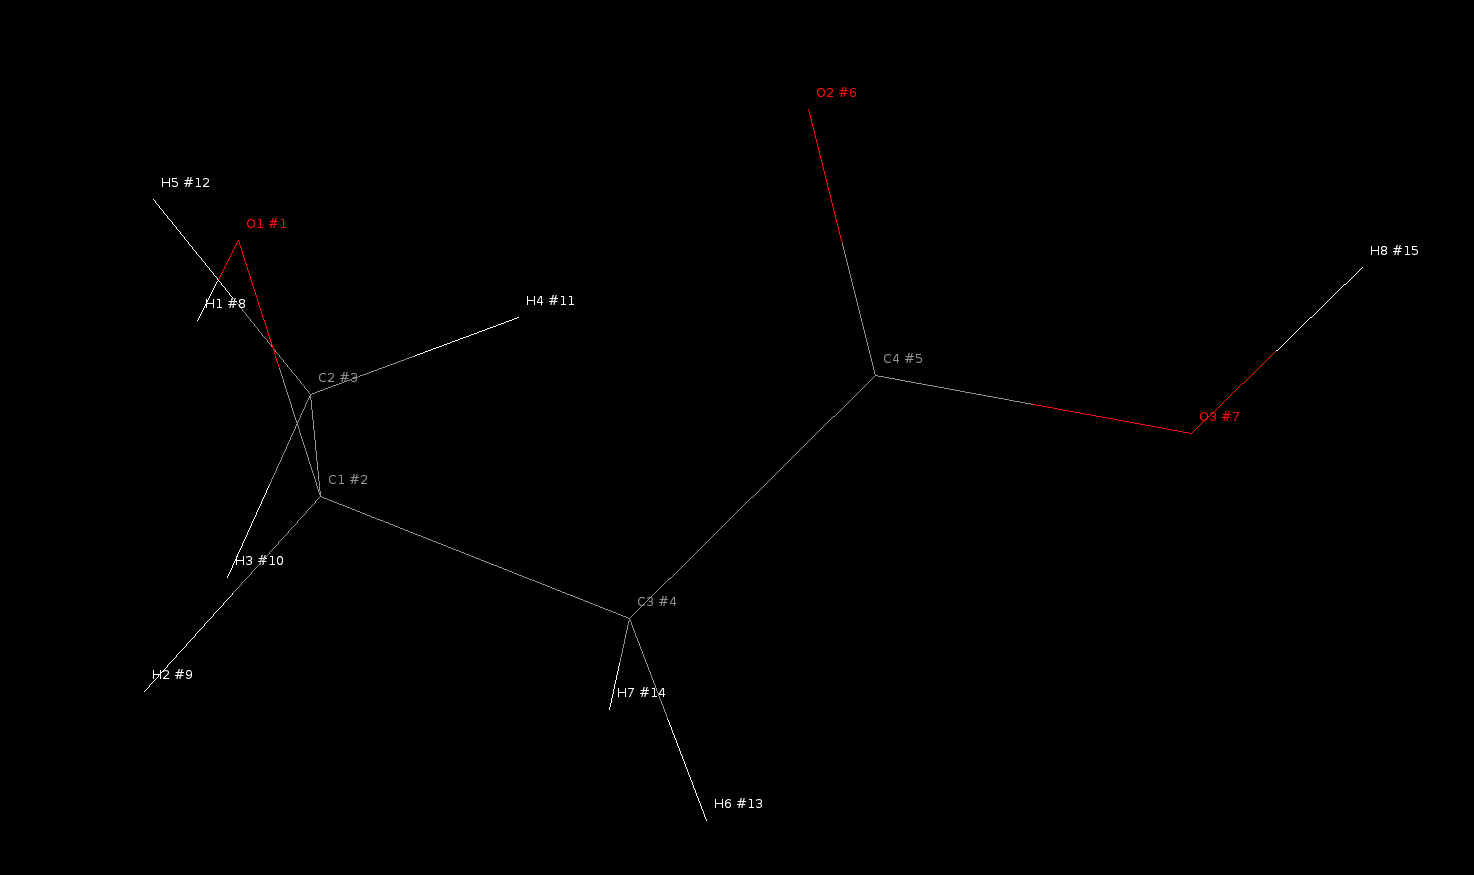

The origin of the error comes from the starting PDB file. At line 20, the atom 5 is double bonded to 6:

```
CONECT    5    6    6    7
```

Let's change that definition at line 20 doing the next modification:

```
CONECT    5    6    7
```

and let's start the residue generation again and save Amber params.

In [7]:
!antechamber -i inputs/3HB_I.pdb -fi pdb -o outputs/3HB_I.mol2 -fo mol2 -c bcc -s 2


Welcome to antechamber 22.0: molecular input file processor.

Info: acdoctor mode is on: check and diagnose problems in the input file.
Info: The atom type is set to gaff; the options available to the -at flag are
      gaff, gaff2, amber, bcc, and sybyl.

-- Check Format for pdb File --
   Status: pass
Info: Determining atomic numbers from atomic symbols which are case sensitive.
-- Check Unusual Elements --
   Status: pass
-- Check Open Valences --
   Status: pass
-- Check Geometry --
      for those bonded   
      for those not bonded   
   Status: pass
-- Check Weird Bonds --
   Status: pass
-- Check Number of Units --
   Status: pass
acdoctor mode has completed checking the input file.

Running: /home/is/prog/miniconda3/envs/openmm/bin/bondtype -j full -i ANTECHAMBER_BOND_TYPE.AC0 -o ANTECHAMBER_BOND_TYPE.AC -f ac
/bin/bash: /home/is/prog/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)

Running: /home/is/prog/miniconda3/envs/ope

No, let's execute the tLeap script called `3HB_I.intleap`:
```
# Load the necessary force field parameters
source leaprc.protein.ff14SB
source leaprc.gaff
3HB  = loadMol2 ./outputs/3HB_I.mol2
list
saveoff 3HB ./outputs/3HB.lib

# Solvate the system
solvateBox 3HB TIP3PBOX 10.0

saveamberparm 3HB ./outputs/3HB.prmtop ./outputs/3HB.rst7
savepdb 3HB ./outputs/3HB_prm.pdb
quit
```

The tLeap script is loaded and the Amber parameters file is created. If an error occurs, don't panic! You may need to load the water models as they may not be included in your version of "leaprc.protein.ff14SB". See below "Issues with running above script".

In [14]:
!tleap -f inputs/3HB_I.intleap

-I: Adding /home/is/prog/miniconda3/envs/openmm/dat/leap/prep to search path.
-I: Adding /home/is/prog/miniconda3/envs/openmm/dat/leap/lib to search path.
-I: Adding /home/is/prog/miniconda3/envs/openmm/dat/leap/parm to search path.
-I: Adding /home/is/prog/miniconda3/envs/openmm/dat/leap/cmd to search path.
-f: Source 3HB_I.intleap.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./3HB_I.intleap
----- Source: /home/is/prog/miniconda3/envs/openmm/dat/leap/cmd/leaprc.protein.ff14SB
----- Source of /home/is/prog/miniconda3/envs/openmm/dat/leap/cmd/leaprc.protein.ff14SB done
Log file: ./leap.log
Loading parameters: /home/is/prog/miniconda3/envs/openmm/dat/leap/parm/parm10.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA
Loading parameters: /home/is/prog/miniconda3/envs/openmm/dat/leap/parm/frcmod.ff14SB
Reading force field modification type file (frcmod)
Reading title:
ff14SB protein backbone and sidechain parameters
Loading library: /home/is/prog/miniconda

### Issues with running above script:

- It loads 2 parameter files:
    - source leaprc.protein.ff14SB
    - source leaprc.gaff
    
When I attempted this, the water model "TIP3PBOX" was not present and i needed an extra parameter file:
- source leaprc.water.fb3

The param files can be found at the following path:
- /home/your_user/miniconda3/enve/AmberTools23/dat/leap/param

So we can execute the tLeap script called `3HB_I.intleap` with these extra parameters:
```
# Load the necessary force field parameters
source leaprc.protein.ff14SB
source leaprc.gaff
source leaprc.water.fb3
3HB  = loadMol2 ./outputs/3HB_I.mol2
list
saveoff 3HB ./outputs/3HB.lib

# Solvate the system
solvateBox 3HB TIP3PBOX 10.0

saveamberparm 3HB ./outputs/3HB.prmtop ./outputs/3HB.rst7
savepdb 3HB ./outputs/3HB_prm.pdb
quit
```

In [ ]:
!tleap -f inputs/3HB_I.intleap

In [15]:
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit

# Load Amber files
prmtop = app.AmberPrmtopFile('./outputs/3HB.prmtop')
inpcrd = app.AmberInpcrdFile('./outputs/3HB.rst7')

# Create system and integrator
system = prmtop.createSystem(nonbondedMethod=app.PME, nonbondedCutoff=1.0*unit.nanometers, constraints=app.HBonds)
integrator = mm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)

# Create simulation
simulation = app.Simulation(prmtop.topology, system, integrator)
simulation.context.setPositions(inpcrd.positions)

# Minimize energy
simulation.minimizeEnergy()

# Set initial velocities
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)

# Run simulation
simulation.reporters.append(app.PDBReporter('output.pdb', 1000))
simulation.reporters.append(app.StateDataReporter('data.csv', 1000, step=True, potentialEnergy=True, temperature=True))
simulation.step(10000)


The above script can be run with the python interperter by typing the following into the terminal:
```shell
python3
```
From here, the above commands can be typed line by line and the simulation will run.

However, it is more useful to save the python script in the linux part of file manager with a name something like "3HB_first_simulation.py" and run the script as below:
```shell
python3 3HB_first_simulation.py
```
This will not open the python interperter but will run the script - this way is more useful as it allows for easier execution of the script.

### Creating polymers

## Automatic parametrization of molecules with Openff and Openmmforcefields

### Using GAFF

https://github.com/openmm/openmmforcefields

https://github.com/openforcefield/openff-toolkit

##### Error when trying to import from openff
"No module called openff" <br>
We need to install the openff-toolkit package. <br>
In the terminal, run the following two commands to install openff-toolkit and the openeye dependency. <br>
There are two other dependcies for openff-toolkit (AmberTools and RDKit) but these should already be installed.
```shell
conda install -c conda-forge openff-toolkit-base
conda install -c openeye openeye-toolkits
```

In [3]:
from openff.toolkit import Molecule
sdf_file = '3HB.sdf'
molecule = Molecule.from_file(sdf_file)

##### Error when trying to import from openmmforcefields
```shell
---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
~\AppData\Local\Temp\ipykernel_1136\3175796480.py in <module>
      1 # Create the GAFF template generator
----> 2 from openmmforcefields.generators import GAFFTemplateGenerator
      3 gaff = GAFFTemplateGenerator(cache='gaff-molecules.json',molecules=molecule)

ModuleNotFoundError: No module named 'openmmforcefields'
```


In [4]:
# Create the GAFF template generator
from openmmforcefields.generators import GAFFTemplateGenerator
gaff = GAFFTemplateGenerator(cache='gaff-molecules.json',molecules=molecule)

ModuleNotFoundError: No module named 'openmmforcefields'

In [3]:
# Create an OpenMM ForceField object with AMBER ff14SB and TIP3P with compatible ions
from openmm.app import ForceField
forcefield = ForceField('amber14/protein.ff14SB.xml', 'amber14/tip3p.xml')
# Register the GAFF template generator
success = forcefield.registerTemplateGenerator(gaff.generator)


In [4]:
print(GAFFTemplateGenerator.INSTALLED_FORCEFIELDS)

['gaff-1.4', 'gaff-1.8', 'gaff-1.81', 'gaff-2.1', 'gaff-2.11']


In [5]:
from openmm.app import PDBFile
mipdbfile = PDBFile('3HB.pdb')
system = forcefield.createSystem(mipdbfile.topology)

/bin/bash: /home/is/prog/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/is/prog/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/is/prog/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/is/prog/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/is/prog/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/is/prog/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [20]:
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.001*picoseconds)
simulation = Simulation(mipdbfile.topology, system, integrator)
simulation.context.setPositions(mipdbfile.positions)

simulation.reporters.append(PDBReporter('output.pdb', 1))
simulation.reporters.append(StateDataReporter(stdout, 1, step=True,
        potentialEnergy=True, temperature=True))
simulation.minimizeEnergy()
simulation.step(10000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1,-252.43954467773438,0.5619224090657543
2,-252.4239501953125,1.0031674420204177
3,-252.39990234375,1.3305509789227026
4,-252.36798095703125,2.552877969831121
5,-252.33453369140625,2.616242982142179
6,-252.29937744140625,2.9709718306374406
7,-252.26190185546875,3.384679004086879
8,-252.220947265625,3.3685721175326644
9,-252.19171142578125,3.755191038086109
10,-252.17776489257812,4.095442437151267
11,-252.11590576171875,4.24881176979983
12,-252.03500366210938,4.517588771104209
13,-252.0242919921875,5.874559556833769
14,-251.99981689453125,6.465008511828945
15,-251.9154052734375,7.036687702450113
16,-251.83416748046875,7.439837807041082
17,-251.801513671875,6.545896188910046
18,-251.80075073242188,7.313337302410683
19,-251.73953247070312,7.526361135288724
20,-251.55450439453125,6.587850567455695
21,-251.40435791015625,6.828440217923833
22,-251.38632202148438,7.162252138462121
23,-251.3974609375,7.96104211897148
24,-251.343994140625,8